In [ ]:
# XGBoost is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library

In [ ]:
%pip install scikit-learn xgboost

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go

In [2]:
# Import Google 10 years closing data
his_data = yf.download("GOOG", start="2011-01-01", end="2022-1-1")
ten_yr_closing=his_data['Close']
df=ten_yr_closing.to_frame()
df.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2010-12-31,14.793799
2011-01-03,15.052330
2011-01-04,14.996788
2011-01-05,15.169890
2011-01-06,15.280226


In [3]:
# Create a targeted column with shift 1
# As the closing price for the next day is the target for the prediction from up to the current date
# X= Close, y=Target
df['Target']=df.Close.shift(-1)
df.dropna(inplace=True) # Remove the last row of data which target value =Nan
df.head()

,Close,Target
Date,,
2010-12-31,14.793799,15.052330
2011-01-03,15.052330,14.996788
2011-01-04,14.996788,15.169890
2011-01-05,15.169890,15.280226
2011-01-06,15.280226,15.353451


### Univariate Model with regression (Without hyperparameter tuning)[ Twist]

In [148]:
#Return 1 single prediction from XGBoost
def xgb_predict(df_train:pd.DataFrame,df_test:pd.DataFrame) -> float:

    # Split X and y
    X_train=df_train.iloc[:,:-1]
    y_train=df_train.iloc[:,-1]
    X_test=df_test.iloc[:,:-1]
    y_test=df_test.iloc[:,-1]
    X_test_pred=X_test.iloc[:1,:]


    # Model building
    from xgboost import XGBRegressor
    model=XGBRegressor()
    model.fit(X_train,y_train)

    # Prediction
    pred=model.predict(X_test_pred)
    return pred[0]

In [164]:
# Iterate through an accumulated trianing set [input=df]
def accu_pred(df:pd.DataFrame,perc_train:float,perc_test:float):

    # Initialisation
    num_train=int(len(df)*perc_train)
    num_test=len(df)-num_train
    y_test=df.iloc[num_train:,:]

    # Loop
    prediction=[] # Store the list of prediction
    for i in range(num_test): # i=1
        accu_Train=df.iloc[:num_train+i,:]
        df_test=df.iloc[num_train+i:,:]
        pred=xgb_predict(accu_Train,df_test)
        prediction.append(pred)
    
    return prediction,y_test

In [166]:
prediction,y_test=accu_pred(df,0.6,0.4)
print('pred',len(prediction))
print('y_test',len(y_test))
df_pred = pd.DataFrame(prediction, index =y_test.index,
                                              columns =['Date'])
df_pred

pred 1108
y_test 1108


,Date
Date,
2017-08-08,46.597031
2017-08-09,46.392574
2017-08-10,45.646965
2017-08-11,45.996170
2017-08-14,45.806885
...,...
2021-12-23,146.782120
2021-12-27,148.518921
2021-12-28,146.255722


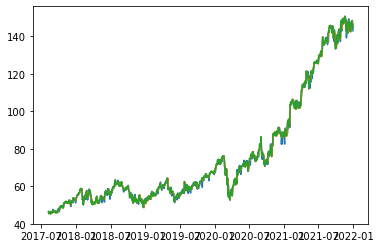

In [167]:
plt.plot(df_pred)
plt.plot(y_test)

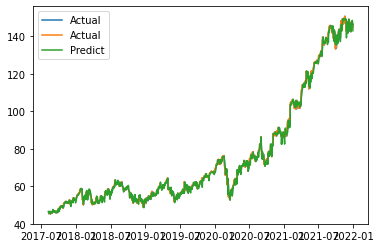

In [173]:
fig, ax = plt.subplots()

ax.plot(y_test.index, y_test, label = 'Actual')
ax.plot(y_test.index, df_pred,label = 'Predict')
ax.legend(loc='upper left')
plt.show()

In [125]:
# Iterate through an accumulated trianing set
def accu_pred(df_train,df_test):

    prediction=[] # Store the list of prediction
    accu_Train=df_train  # Accumulated training data; Initialise with df_train
    y_test=df_test.iloc[:,-1] # For evaluation

    for i in range(len(df_test)):
        
        df_test=df_test.iloc[i: , :] # Iteratively remove the first row of df_test (start with all df_test)
        df_test_first_row=df_test.iloc[0:1,:] # Store the first row 
        
        pred=xgb_predict(accu_Train,df_test)
        prediction.append(pred)
        accu_Train=pd.concat([accu_Train, df_test_first_row], axis=0)
    
    return prediction,y_test

         
    

In [126]:
pred,y_test=accu_pred(train,test)

In [129]:
len([p for p in pred if p == 'probelmatic'])

1061

In [122]:
len(test)
len(pred)

1108

In [131]:
print('pred',pred)
print('y_test',y_test)
print('y_test len',len(y_test))
print('diff',len(train)-len(test))
print(len([p for p in pred if p is None]))

pred [46.59703, 46.392574, 45.971355, 46.631844, 46.172092, 45.629173, 47.07027, 46.067223, 47.333393, 48.762413, 48.99012, 49.32672, 51.336967, 51.073223, 53.800377, 55.244682, 55.29504, 56.298393, 51.33491, 54.905262, 55.312717, 58.430992, 58.43379, 58.492104, 56.467686, 51.828365, 51.396957, 54.909424, 61.81647, 58.7302, 54.84342, 60.261772, 60.31138, 61.807236, 62.934135, 67.72604, 56.328762, 67.7869, 75.372856, 75.42051, 77.862, 86.95217, 88.2624, 103.013695, 113.03084, 131.7654, 138.94054, 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'probelmatic', 'pro

In [96]:
#print(test.iloc[:,:-1].iloc[:1,:])
#type(test.iloc[:,:-1])
#print(len(test.iloc[1: , :]))
# print(len(test))
# #print(test.iloc[1: , :].iloc[:,:-1].iloc[:1,:])
# print(test.index[0])
# print(test.loc(test.index[0]))
# print(test.drop(index=test.index[0],axis=0))
print('ori', test)
print('first',test.iloc[0:1,:])
removed=test.iloc[1: , :]
print('removed',removed)
print('first_it',removed.iloc[0:1,:])

ori                  Close      Target
Date                              
2017-08-08   46.339500   46.145000
2017-08-09   46.145000   45.362000
2017-08-10   45.362000   45.719501
2017-08-11   45.719501   46.133499
2017-08-14   46.133499   46.111000
...                ...         ...
2021-12-23  147.142502  148.063995
2021-12-27  148.063995  146.447998
2021-12-28  146.447998  146.504501
2021-12-29  146.504501  146.002502
2021-12-30  146.002502  144.679504

[1108 rows x 2 columns]
first               Close  Target
Date                       
2017-08-08  46.3395  46.145
removed                  Close      Target
Date                              
2017-08-09   46.145000   45.362000
2017-08-10   45.362000   45.719501
2017-08-11   45.719501   46.133499
2017-08-14   46.133499   46.111000
2017-08-15   46.111000   46.348000
...                ...         ...
2021-12-23  147.142502  148.063995
2021-12-27  148.063995  146.447998
2021-12-28  146.447998  146.504501
2021-12-29  146.504501  146.00250

In [28]:
trial_model=xgb_predict(train,test)
trial_model

,Close
Date,
2017-08-08,46.3395
2017-08-09,46.1450
2017-08-10,45.3620


In [33]:
df.iloc[:,:-1]

,Close
Date,
2010-12-31,14.793799
2011-01-03,15.052330
2011-01-04,14.996788
2011-01-05,15.169890
2011-01-06,15.280226
...,...
2021-12-23,147.142502
2021-12-27,148.063995
2021-12-28,146.447998


### Univariate Model with regression (Without hyperparameter tuning)

In [ ]:
# Train Test Split 
def train_test_split(data:pd.DataFrame,perc_train:float,perc_test:float) :
    data=data.values # Turn into np.array, Remove col name
    num_train=int(len(data)*perc_train)
    num_test=len(data)-num_train
    return data[:num_train,:],data[num_train:,:]

In [ ]:
# Model Training with Prediction
def uni_model_pred (train_data:np.array, test_x:np.array) -> float: # Univariate model with built in optimisation for regression
    
    train_X=train_data[:,:-1]
    train_y=train_data[:,-1]
    from xgboost import XGBRegressor
    model=XGBRegressor(objective="reg:squarederror") 
    model.fit(train_X,train_y) # Optimal model is generated with min requrederror

    # Predict
    test_x=np.array(test_x).reshape(1,-1)
    pred=model.predict(test_x)

    return pred[0]


In [ ]:
def rolling_validate(train_data:np.array, test_data:np.array):
    ''' 
    This function aims at accumulating training data for each prediction 
    ie. The last prediction is based on the model trained by data from the beginning up until the second last data point
    '''
    prediction=[] 
    rolling_data=[x for x in train_data]
    
    for i in range(len(test_data)):
        pred=uni_model_pred (rolling_data, test_data[i][0]) 
        prediction.append(pred)
        rolling_data.append(test_data[i])
    
    #Evaluate
    from sklearn.metrics import mean_absolute_error
    print('test_data',test_data)
    mse=mean_absolute_error(test_data[:,-1],prediction)

    return mse,test_data[:,-1],prediction

In [127]:
# Train Test Split 
def train_test_split(data:pd.DataFrame,perc_train:float,perc_test:float) :
    data=data.values # Turn into np.array, Remove col name
    num_train=int(len(data)*perc_train)
    num_test=len(data)-num_train
    return data[:num_train,:],data[num_train:,:]

In [128]:
# Model Training with Prediction
def uni_model_pred (train_data:np.array, test_x:np.array) -> float: # Univariate model with built in optimisation for regression
    
    train_X=train_data[:,:-1]
    train_y=train_data[:,-1]
    from xgboost import XGBRegressor
    model=XGBRegressor(objective="reg:squarederror") 
    model.fit(train_X,train_y) # Optimal model is generated with min requrederror

    # Predict
    test_x=np.array(test_x).reshape(1,-1)
    pred=model.predict(test_x)

    return pred[0]


In [133]:
def rolling_validate(train_data:np.array, test_data:np.array):
    ''' 
    This function aims at accumulating training data for each prediction 
    ie. The last prediction is based on the model trained by data from the beginning up until the second last data point
    '''
    prediction=[] 
    rolling_data=[x for x in train_data]
    
    for i in range(len(test_data)):
        pred=uni_model_pred (rolling_data, test_data[i][0]) 
        prediction.append(pred)
        rolling_data.append(test_data[i])
    
    #Evaluate
    from sklearn.metrics import mean_absolute_error
    print('test_data',test_data)
    mse=mean_absolute_error(test_data[:,-1],prediction)

    return mse,test_data[:,-1],prediction

### Multivariate (With hyperparameter tunning)

In [ ]:
# Train Validation Test Split [!!! np.array]
def train_valid_test_split(data,perc_train,perc_valid,perc_test):
    num_train=int(len(data)*perc_train)
    num_valid=int(len(data)*perc_valid)
    num_test=len(data)-num_train-num_valid
    return data.iloc[:num_train,:],data.iloc[num_train:num_train+num_valid,:],data.iloc[num_train+num_valid:,:]